# Checkpoint 3

Objective:

The goal of the this test is to achieve a NLP model that can correctly manage the incoming messages on SMS format (`ham` or `spam`). Considering a real scenario, assume that a regular person does not agree to see a `spam` message, however, a normal message (`ham`) can be somethimes be allocated at the `spam` box.

## Import libs


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import nltk

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score


nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/ivyna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import data

In [11]:
data = pd.read_csv('../TrainingSet/sms-hamspam-train.csv', 
                   sep = '\t', 
                   names=['label', 'message'])
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,spam,"SMSSERVICES. for yourinclusive text credits, p..."
2,spam,25p 4 alfie Moon's Children in need song on ur...
3,spam,U have a secret admirer. REVEAL who thinks U R...
4,spam,"Dear Voucher Holder, To claim this weeks offer..."


## Exploratory data analysis

Before applying NLP concepts to the checkpoint, let's get to know a little bit of data by exploring it.

In [12]:
data.describe()

,label,message
count,4725,4725
unique,2,4423
top,ham,"Sorry, I'll call later"
freq,4100,24


You can see that there are 4725 messages, classified as spam or ham as described in the checkpoint objectives.

### Knowing this, how is the distribution of labels in the data?

<AxesSubplot:xlabel='label', ylabel='count'>

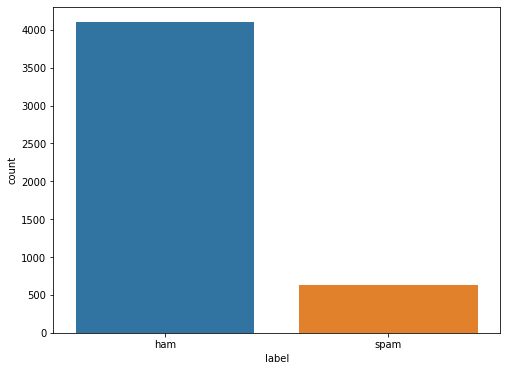

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(data.label)

You can see that there is a greater presence of messages like `ham`, like about 4000 cases and for `spam` we have just over 500 observations.

Now let's look at the words used in spam and ham messages through a worl cloud.

In [14]:
ham_msg = data[data.label == 'ham']
spam_msg = data[data.label == 'spam']
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

#### Word cloud: Ham

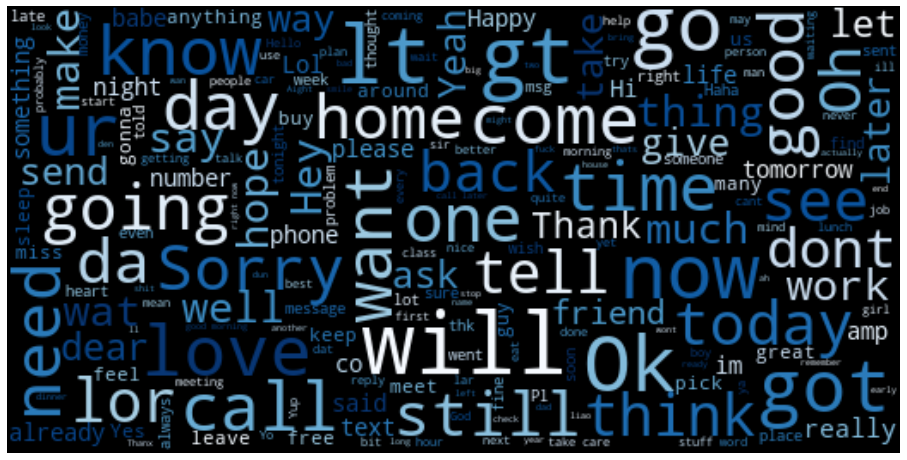

In [15]:
ham_msg_cloud = WordCloud(width = 520, 
                          height = 260, 
                          stopwords = STOPWORDS,
                          max_font_size = 50, 
                          background_color = 'black', 
                          colormap = 'Blues').generate(ham_msg_text)

plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Word cloud: Spam

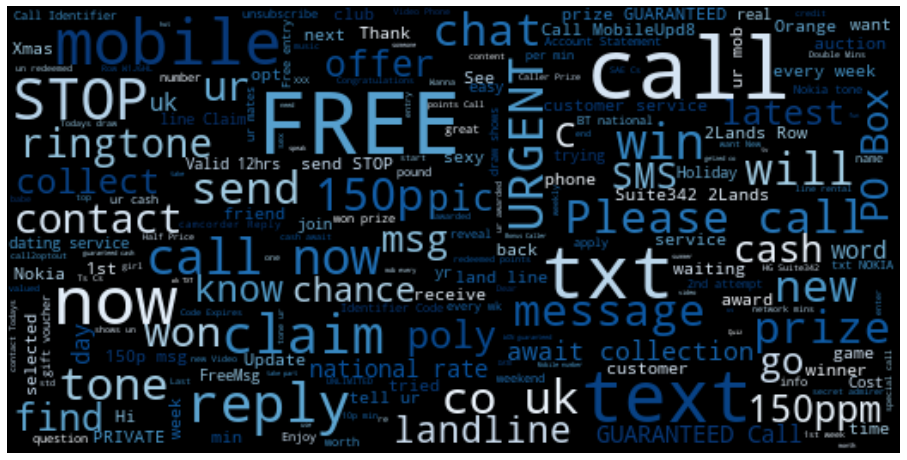

In [16]:
spam_msg_cloud = WordCloud(width = 520, 
                           height = 260, 
                           stopwords = STOPWORDS,
                           max_font_size = 50, 
                           background_color = 'black', 
                           colormap = 'Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Transform data

After exploring a little bit of the data set, for a better classification accuracy, it is necessary to carry out a treatment on the data, being they remove the stopwords, make the words uniform with the lowercase application, remove special characters and turn them into tokens.

In [17]:
def lower_case_messages(msg):
    """
    Convert messages to lowercase.
    
    Args:
        msg: message string
    Return:
        Messages in lowercase
    """
    return "".join([word.lower() for word in msg])

def remove_pt(message):
    """
    Remove punctuation of message.
    
    Args:
        message: sms string
    Return:
        Messages without ponctuation
    """
    
    return "".join([letter for letter in message if letter not in string.punctuation])

def remove_stopwords(msg):
    """
    Remove stopwords
    
    Args:
        msg: message string
        
    Return:
        Remove all stopwords
    """
    return " ".join([word for word in msg.split() if word not in stopwords.words('english')])

def stemming(msg):
    """
    Stem messages
    
    Args:
        message: sms string
    Returns:
        Stemmed message
    """
    
    porter = nltk.PorterStemmer()
    msg_st = msg.split()
    
    return " ".join([porter.stem(word) for word in msg_st])

def format_data(data, test = False):
    """
    Apply methods nlp and create cols in dataframe
    
    Args:
        data: sms dataframe
    Return:
        Data sms
    """
    
    data['lower_case'] = data.apply(lambda x: lower_case_messages(x['message']), axis = 1)
    data['del_pt'] = data.apply(lambda x: remove_pt(x['lower_case']), axis = 1)
    data['del_sw'] = data.apply(lambda x: remove_stopwords(x['del_pt']), axis = 1)
    data['stem_message'] = data.apply(lambda x: stemming(x['del_sw']), axis = 1)
    
    if test:
        data.drop(['lower_case', 'del_sw', 'del_pt'],axis=1, inplace=True)
    else:   
        data.drop(['message', 'lower_case', 'del_sw', 'del_pt'],axis=1, inplace=True)

    return data


def tf_idf_vectorizer(tf_idf, data):
    """
    Create dataframe with tf_idf
    
    Args:
        tf_idf: tf_idf vectorizer instance
        data: sms dataframe
    Return:
        Dataframe with tf_idf 
    """
    tf_idf_vec = tf_idf.fit_transform(data.stem_message)
    tf_idf_df = pd.DataFrame(tf_idf_vec.toarray())
    
    return tf_idf_df

In [18]:
data = format_data(data, False)
data.head()

,label,stem_message
0,ham,go jurong point crazi avail bugi n great world...
1,spam,smsservic yourinclus text credit pl goto wwwco...
2,spam,25p 4 alfi moon children need song ur mob tell...
3,spam,u secret admir reveal think u r special call 0...
4,spam,dear voucher holder claim week offer pc pleas ...


Foi utilizado TF IDF, que consiste na técnica de cálculo de importância do termo em um *corpus*.

In [19]:
tf_idf = TfidfVectorizer()

In [20]:
tf_idf_df = tf_idf_vectorizer(tf_idf, data)

In [21]:
data.drop(['stem_message'], 
          axis = 1, 
          inplace = True)

tf_idf_data = pd.concat([data, tf_idf_df], 
                        axis = 1, 
                        sort = False)

tf_idf_data.drop(['label'], 
                 axis = 1, 
                 inplace = True)

## Train data

To conduct the training, we will share the train data.

In [22]:
sms_train, sms_test, label_train, label_test = train_test_split(tf_idf_data, 
                                                                data['label'], 
                                                                test_size = 0.2)

Here the naive baiyes was used as a classifier, as it is an algorithm widely used for classification in solutions for NLP due to its simplicity and high performance.

In [25]:
model = MultinomialNB()

fit = model.fit(sms_train, label_train)

In [26]:
model_pred = fit.predict(sms_test)

After training, it is interesting to observe some metrics and check the model's accuracy.

In [27]:
precision, recall, fscore, _ = score(label_test, model_pred, pos_label = 'spam', average = 'binary')
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 score: {}'.format(fscore))

Precision: 0.9880952380952381
Recall: 0.7410714285714286
F1 score: 0.8469387755102041


In [28]:
acc = round((model_pred == label_test).sum() / len(model_pred), 4) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 96.83%


We can see that there are results, in view of the values obtained, we have good results in the three parameters analyzed.

Then, we have the calculation and result of the model's accuracy, which in turn is also a good result, above 90%.

For a more detailed analysis, a confusion matrix was created. In which is a table showing the classification frequencies for each class of the model, a tool widely used for evaluations of classification models.

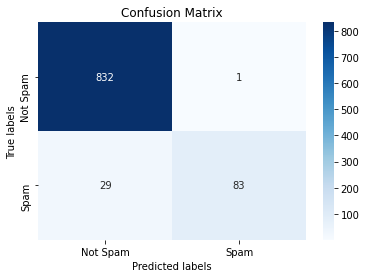

In [29]:
cf_matrix = confusion_matrix(label_test, 
                             model_pred)
ax = plt.subplot()

sns.heatmap(cf_matrix, 
            annot=True, 
            ax = ax, 
            cmap = 'Blues',
            fmt = '');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

When analyzing the confusion matrix, we have good results since the model was able to detect a good number of spam and ham messages, with the spaces of false negative and true positive.

## Import data test

In [30]:
data_test = pd.read_csv('../TestSet/sms-hamspam-test.csv', 
                        sep = '\t', 
                        names = ["message"])
data_test.head()

,message
0,I know that my friend already told that.
1,It took Mr owl 3 licks
2,Dunno y u ask me.
3,K.k:)advance happy pongal.
4,I know but you need to get hotel now. I just g...


In the test set, data normalization techniques such as stopwords and punctuation removal are also applied.

In [31]:
data_test['lower_case'] = data_test.apply(lambda x: lower_case_messages(x['message']), axis = 1)
data_test['del_pt'] = data_test.apply(lambda x: remove_pt(x['lower_case']), axis = 1)
data_test['del_sw'] = data_test.apply(lambda x: remove_stopwords(x['del_pt']), axis = 1)
data_test['stem_message'] = data_test.apply(lambda x: stemming(x['del_sw']), axis = 1)

data_test.drop(['lower_case', 'del_sw', 'del_pt'], 
               axis = 1, 
               inplace = True)

In [32]:
tf_idf_vec = tf_idf.transform(data_test.stem_message)
tf_idf_df_test = pd.DataFrame(tf_idf_vec.toarray())

In [33]:
data_test.drop(['stem_message'], 
               axis = 1, 
               inplace = True)

tf_idf_data_test = pd.concat([data_test, tf_idf_df_test], 
                             axis = 1, 
                             sort = False)

In [34]:
result = {
    "label": [],
    "message": tf_idf_data_test.message
}

tf_idf_data_test.drop(['message'], 
                      axis = 1, 
                      inplace = True)

Using the naive baiyes model previously trained, the author of the text is predicted with the test data set and create the answer file.

In [35]:
model_pred_test = model.predict(tf_idf_data_test)

In [36]:
result["label"] = model_pred_test
rp = pd.DataFrame(result)

In [37]:
rp.to_csv('../data/spam_detect_nb.csv', 
          index = False)